# Signal Burst Detection in Noisy Environments
Detecting start and end times of burst-like signals using frequency filtering.


📦 Imports and Setup

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, hilbert, butter, filtfilt
from scipy.stats import linregress
plt.close('all')


🔊 Signal Generator Functions

In [6]:
def generate_boxcar_signal(fs, duration, t_start, t_end, f0, noise_std=0.02):
    t = np.arange(0, duration, 1/fs)
    window = ((t >= t_start) & (t < t_end)).astype(float)
    shifted_t = t - t_start
    carrier = np.sin(2 * np.pi * f0 * shifted_t)
    noise = np.random.normal(scale=noise_std, size=t.shape)
    return t, window * carrier + noise

def generate_ramp_up_signal(fs, duration, t_start, t_end, f0, noise_std=0.02, slope=0.3):
    t = np.arange(0, duration, 1/fs)
    window = np.zeros_like(t)
    m = (t >= t_start) & (t < t_end)
    window[m] = slope * (t[m] - t_start)
    shifted_t = t - t_start
    carrier = np.sin(2 * np.pi * f0 * shifted_t)
    noise = np.random.normal(scale=noise_std, size=t.shape)
    return t, window * carrier + noise

def generate_ramp_down_signal(fs, duration, t_start, t_end, f0, noise_std=0.02, slope=0.3):
    t = np.arange(0, duration, 1/fs)
    window = np.zeros_like(t)
    m = (t >= t_start) & (t < t_end)
    window[m] = slope * (t_end - t[m])
    shifted_t = t - t_start
    carrier = np.sin(2 * np.pi * f0 * shifted_t)
    noise = np.random.normal(scale=noise_std, size=t.shape)
    return t, window * carrier + noise


📍 Burst Detection Algorithm

In [7]:
def detect_bounds_via_threshold(x, fs, f0, shape,
                                template_len_sec=0.02,
                                cross=0.5,
                                env_lp_cutoff=None):
    
    """ 
    Detect start and end times of a burst-like signal using frequency filtering
    
    Args:
        x (np.ndarray): Input signal.
        fs (float): Sampling frequency.
        f0 (float): Frequency of the signal.
        shape (str): Shape of the signal ('boxcar', 'ramp_up', 'ramp_down').
        template_len_sec (float): Length of the template in seconds.
        cross (float): Threshold for envelope detection.
        env_lp_cutoff (float, optional): Cutoff frequency for low-pass filter on envelope.  
    
    Returns:
        t_start (float): Start time of the detected signal.
        t_end (float): End time of the detected signal.
        env (np.ndarray): Envelope of the correlation.
        
    """
    # Create a template kernel for frequency filtering
    
    L = int(template_len_sec * fs)
    t_temp = np.arange(L) / fs
    kernel = np.sin(2 * np.pi * f0 * t_temp)
    kernel /= np.linalg.norm(kernel)

    # find the correlation of the input signal with the kernel
    corr = correlate(x, kernel, mode='same')
    env = np.abs(hilbert(corr))


    # Normalize the envelope
    cutoff = env_lp_cutoff or (f0 / 2)
    b, a = butter(4, cutoff, fs=fs, btype='low')
    env = filtfilt(b, a, env)
    env /= np.max(env)
    
    # Smooth the envelope slighly to find the gradient, this gradient is used to find the ramp up and ramp down 
    b2, a2 = butter(4, 20, fs=fs, btype='low')
    env_smooth = filtfilt(b2, a2, env)
    d_env = np.gradient(env_smooth)

    # Find the indices where the envelope crosses the value 0.5 for square-like signals
    above = env >= cross
    indices = np.where(above)[0]
    if indices.size == 0:
        return None, None, env

    idx_start = indices[0] - 1  # to include the first index before crossing
    idx_end = indices[-1] + 1  # to include the last index after crossing
    t_start = idx_start / fs
    t_end = idx_end / fs

    t = np.arange(len(x)) / fs      

    # Adjust start and end times based on the shape of the signal for ramp-like signals

    if shape in ['ramp_up', 'halftriangle_start_with_ramp']:
        mask = (env > 0.2) & (env < 0.8) & (d_env > 0)
        t_linear = t[mask]
        env_linear = env_smooth[mask]
        slope, intercept = linregress(t_linear, env_linear)[:2]
        t_start = -intercept / slope

    elif shape in ['ramp_down', 'halftriangle_end_with_ramp']:
        mask = (env > 0.2) & (env < 0.8) & (d_env < 0)
        t_linear = t[mask]
        env_linear = env_smooth[mask]
        slope, intercept = linregress(t_linear, env_linear)[:2]
        t_end = -intercept / slope

    return t_start, t_end, env


▶️ Main Execution and Visualization



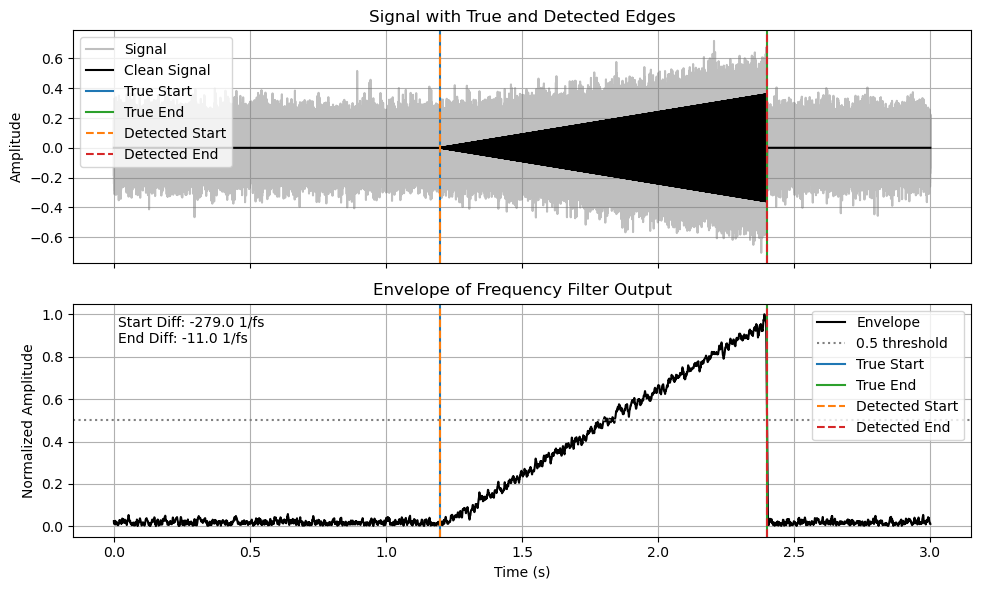

In [55]:
def main():
    fs = 100_000
    f0 = 1000
    true_start, true_end = 1.2, 2.4
    duration = 3.0
    shape = 'ramp_up'  # Options: 'boxcar', 'ramp_up', 'ramp_down'
    noise_std = 0.1
    
    if shape in ['boxcar', 'flat']:
        t, x = generate_boxcar_signal(fs, duration, true_start, true_end, f0, noise_std)
    elif shape in ['ramp_up', 'halftriangle_start_with_ramp']:
        t, x = generate_ramp_up_signal(fs, duration, true_start, true_end, f0, noise_std)
    elif shape in ['ramp_down', 'halftriangle_end_with_ramp']:
        t, x = generate_ramp_down_signal(fs, duration, true_start, true_end, f0, noise_std)
    else:
        raise ValueError(f"Unsupported shape: {shape}")
    
    detected_start, detected_end, env = detect_bounds_via_threshold(
        x, fs, f0, shape, template_len_sec=2*np.pi/f0, cross=0.5)
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    ax[0].plot(t, x, color='grey', label='Signal', alpha=0.5)
    #plot the real signal without noise
    t_clean, x_clean = generate_ramp_up_signal(fs, duration, true_start, true_end, f0, noise_std=0.0)
    ax[0].plot(t_clean, x_clean, color='black', label='Clean Signal')

    ax[0].axvline(true_start, color='C0', linestyle='-', label='True Start')
    ax[0].axvline(true_end, color='C2', linestyle='-', label='True End')
    if detected_start is not None:
        ax[0].axvline(detected_start, color='C1', linestyle='--', label='Detected Start')
        ax[0].axvline(detected_end, color='C3', linestyle='--', label='Detected End')
    ax[0].set_title('Signal with True and Detected Edges')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend()
    ax[0].grid()
    
    ax[1].plot(t, env, color='black', label='Envelope')
    ax[1].axhline(0.5, color='gray', linestyle=':', label='0.5 threshold')
    ax[1].axvline(true_start, color='C0', linestyle='-', label='True Start')
    ax[1].axvline(true_end, color='C2', linestyle='-', label='True End')
    if detected_start is not None:
        ax[1].axvline(detected_start, color='C1', linestyle='--', label='Detected Start')
        ax[1].axvline(detected_end, color='C3', linestyle='--', label='Detected End')
    ax[1].set_title('Envelope of Frequency Filter Output')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Normalized Amplitude')
    ax[1].legend()
    ax[1].grid()
    
    if detected_start is not None:
        diff_start = (detected_start - true_start) // (1/fs)
        diff_end = (detected_end - true_end) // (1/fs)
        ax[1].text(0.05, 0.95,
                   f'Start Diff: {diff_start} 1/fs\nEnd Diff: {diff_end} 1/fs',
                   transform=ax[1].transAxes, fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
main()




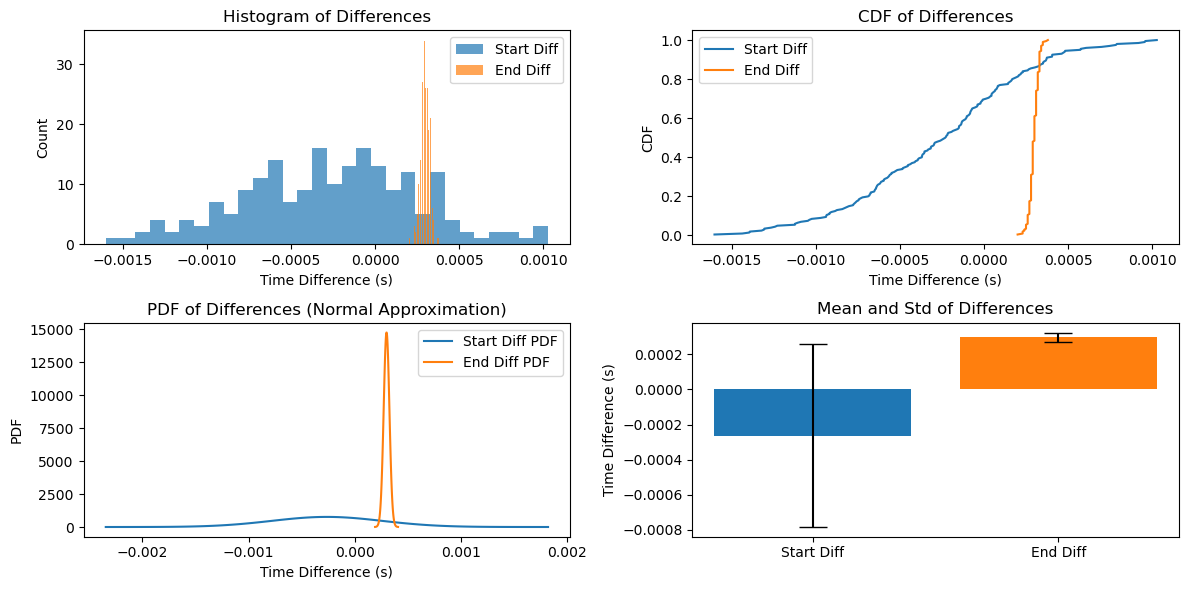

Start Diff: mean in dt= -26.396247, std = 52.037208
End Diff: mean in dt= 29.740000, std = 2.700444


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_detections(n_trials=100, fs=100_000, f0=100, duration=3.0, shape='ramp_up', noise_std=0.01):
    true_start, true_end = 1.2, 2.4
    start_diffs = []
    end_diffs = []
    for _ in range(n_trials):
        if shape in ['boxcar', 'flat']:
            t, x = generate_boxcar_signal(fs, duration, true_start, true_end, f0, noise_std)
        elif shape in ['ramp_up', 'halftriangle_start_with_ramp']:
            t, x = generate_ramp_up_signal(fs, duration, true_start, true_end, f0, noise_std)
        elif shape in ['ramp_down', 'halftriangle_end_with_ramp']:
            t, x = generate_ramp_down_signal(fs, duration, true_start, true_end, f0, noise_std)
        else:
            raise ValueError(f"Unsupported shape: {shape}")
        detected_start, detected_end, _ = detect_bounds_via_threshold(x, fs, f0, shape, template_len_sec=2*np.pi/f0, cross=0.5)
        if detected_start is not None and detected_end is not None:
            start_diffs.append(detected_start - true_start)
            end_diffs.append(detected_end - true_end)
    return np.array(start_diffs), np.array(end_diffs)

# Simulate multiple trials
start_diffs, end_diffs = simulate_detections(n_trials=200)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(start_diffs, bins=30, alpha=0.7, label='Start Diff')
plt.hist(end_diffs, bins=30, alpha=0.7, label='End Diff')
plt.title('Histogram of Differences')
plt.xlabel('Time Difference (s)')
plt.ylabel('Count')
plt.legend()

# Plot CDF
plt.subplot(2, 2, 2)
for diffs, label in zip([start_diffs, end_diffs], ['Start Diff', 'End Diff']):
    sorted_diffs = np.sort(diffs)
    cdf = np.arange(1, len(sorted_diffs)+1) / len(sorted_diffs)
    plt.plot(sorted_diffs, cdf, label=label)
plt.title('CDF of Differences')
plt.xlabel('Time Difference (s)')
plt.ylabel('CDF')
plt.legend()

# Plot PDF (using kernel density estimate)
plt.subplot(2, 2, 3)
for diffs, label in zip([start_diffs, end_diffs], ['Start Diff', 'End Diff']):
    mu, std = np.mean(diffs), np.std(diffs)
    x_vals = np.linspace(mu - 4*std, mu + 4*std, 100)
    pdf = norm.pdf(x_vals, mu, std)
    plt.plot(x_vals, pdf, label=f'{label} PDF')
plt.title('PDF of Differences (Normal Approximation)')
plt.xlabel('Time Difference (s)')
plt.ylabel('PDF')
plt.legend()

# Plot mean and std
plt.subplot(2, 2, 4)
means = [np.mean(start_diffs), np.mean(end_diffs)]
stds = [np.std(start_diffs), np.std(end_diffs)]
labels = ['Start Diff', 'End Diff']
plt.bar(labels, means, yerr=stds, capsize=10, color=['C0', 'C1'])
plt.title('Mean and Std of Differences')
plt.ylabel('Time Difference (s)')

plt.tight_layout()
plt.show()


fs= 100_000  # Sampling frequency

print(f"Start Diff: mean in dt= {fs*np.mean(start_diffs):.6f}, std = {fs*np.std(start_diffs):.6f}")
print(f"End Diff: mean in dt= {fs*np.mean(end_diffs):.6f}, std = {fs*np.std(end_diffs):.6f}")

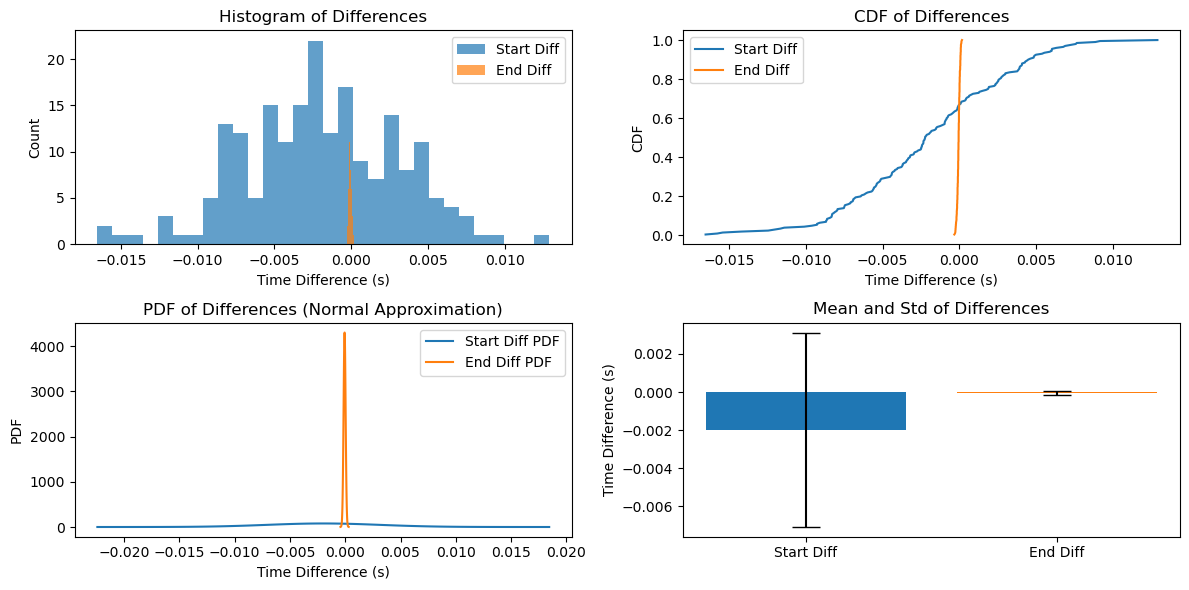

Start Diff: mean in dt= -198.132592, std = 510.433819
End Diff: mean in dt= -5.475000, std = 9.269270


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_detections(n_trials=100, fs=100_000, f0=1000, duration=3.0, shape='ramp_up', noise_std=0.1):
    true_start, true_end = 1.2, 2.4
    start_diffs = []
    end_diffs = []
    for _ in range(n_trials):
        if shape in ['boxcar', 'flat']:
            t, x = generate_boxcar_signal(fs, duration, true_start, true_end, f0, noise_std)
        elif shape in ['ramp_up', 'halftriangle_start_with_ramp']:
            t, x = generate_ramp_up_signal(fs, duration, true_start, true_end, f0, noise_std)
        elif shape in ['ramp_down', 'halftriangle_end_with_ramp']:
            t, x = generate_ramp_down_signal(fs, duration, true_start, true_end, f0, noise_std)
        else:
            raise ValueError(f"Unsupported shape: {shape}")
        detected_start, detected_end, _ = detect_bounds_via_threshold(x, fs, f0, shape, template_len_sec=2*np.pi/f0, cross=0.5)
        if detected_start is not None and detected_end is not None:
            start_diffs.append(detected_start - true_start)
            end_diffs.append(detected_end - true_end)
    return np.array(start_diffs), np.array(end_diffs)

# Simulate multiple trials
start_diffs, end_diffs = simulate_detections(n_trials=200)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(start_diffs, bins=30, alpha=0.7, label='Start Diff')
plt.hist(end_diffs, bins=30, alpha=0.7, label='End Diff')
plt.title('Histogram of Differences')
plt.xlabel('Time Difference (s)')
plt.ylabel('Count')
plt.legend()

# Plot CDF
plt.subplot(2, 2, 2)
for diffs, label in zip([start_diffs, end_diffs], ['Start Diff', 'End Diff']):
    sorted_diffs = np.sort(diffs)
    cdf = np.arange(1, len(sorted_diffs)+1) / len(sorted_diffs)
    plt.plot(sorted_diffs, cdf, label=label)
plt.title('CDF of Differences')
plt.xlabel('Time Difference (s)')
plt.ylabel('CDF')
plt.legend()

# Plot PDF (using kernel density estimate)
plt.subplot(2, 2, 3)
for diffs, label in zip([start_diffs, end_diffs], ['Start Diff', 'End Diff']):
    mu, std = np.mean(diffs), np.std(diffs)
    x_vals = np.linspace(mu - 4*std, mu + 4*std, 100)
    pdf = norm.pdf(x_vals, mu, std)
    plt.plot(x_vals, pdf, label=f'{label} PDF')
plt.title('PDF of Differences (Normal Approximation)')
plt.xlabel('Time Difference (s)')
plt.ylabel('PDF')
plt.legend()

# Plot mean and std
plt.subplot(2, 2, 4)
means = [np.mean(start_diffs), np.mean(end_diffs)]
stds = [np.std(start_diffs), np.std(end_diffs)]
labels = ['Start Diff', 'End Diff']
plt.bar(labels, means, yerr=stds, capsize=10, color=['C0', 'C1'])
plt.title('Mean and Std of Differences')
plt.ylabel('Time Difference (s)')

plt.tight_layout()
plt.show()


fs= 100_000  # Sampling frequency

print(f"Start Diff: mean in dt= {fs*np.mean(start_diffs):.6f}, std = {fs*np.std(start_diffs):.6f}")
print(f"End Diff: mean in dt= {fs*np.mean(end_diffs):.6f}, std = {fs*np.std(end_diffs):.6f}")

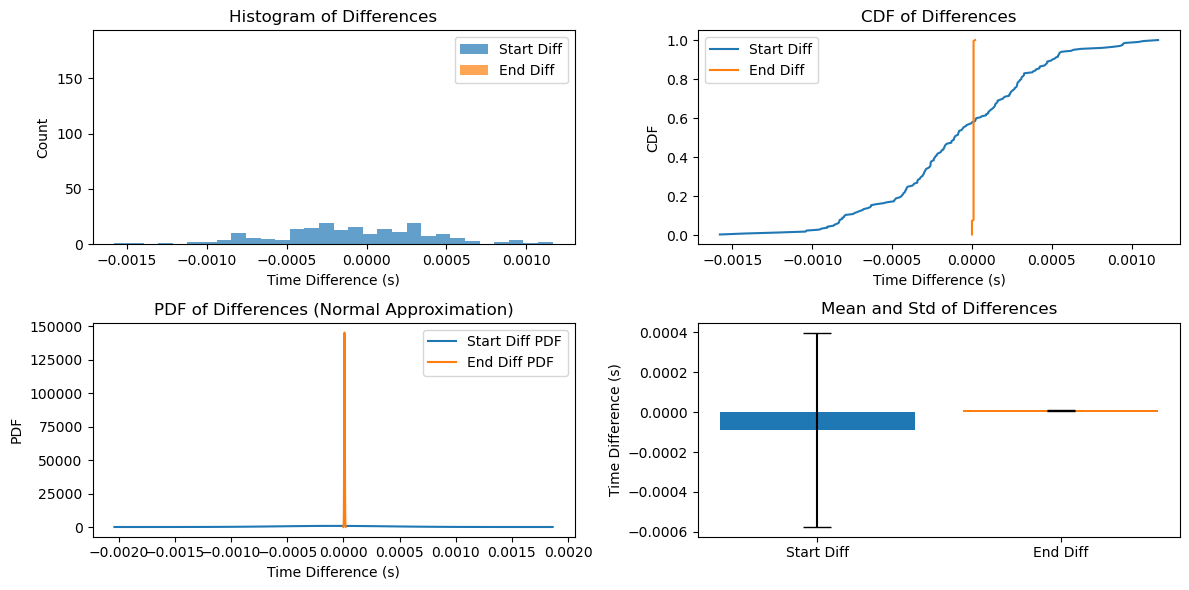

Start Diff: mean in dt= -8.842092, std = 48.766825
End Diff: mean in dt= 0.930000, std = 0.274044


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_detections(n_trials=200, fs=100_000, f0=10000, duration=3.0, shape='ramp_up', noise_std=0.01):
    true_start, true_end = 1.2, 2.4
    start_diffs = []
    end_diffs = []
    for _ in range(n_trials):
        if shape in ['boxcar', 'flat']:
            t, x = generate_boxcar_signal(fs, duration, true_start, true_end, f0, noise_std)
        elif shape in ['ramp_up', 'halftriangle_start_with_ramp']:
            t, x = generate_ramp_up_signal(fs, duration, true_start, true_end, f0, noise_std)
        elif shape in ['ramp_down', 'halftriangle_end_with_ramp']:
            t, x = generate_ramp_down_signal(fs, duration, true_start, true_end, f0, noise_std)
        else:
            raise ValueError(f"Unsupported shape: {shape}")
        detected_start, detected_end, _ = detect_bounds_via_threshold(x, fs, f0, shape, template_len_sec=2*np.pi/f0, cross=0.5)
        if detected_start is not None and detected_end is not None:
            start_diffs.append(detected_start - true_start)
            end_diffs.append(detected_end - true_end)
    return np.array(start_diffs), np.array(end_diffs)

# Simulate multiple trials
start_diffs, end_diffs = simulate_detections(n_trials=200)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(start_diffs, bins=30, alpha=0.7, label='Start Diff')
plt.hist(end_diffs, bins=30, alpha=0.7, label='End Diff')
plt.title('Histogram of Differences')
plt.xlabel('Time Difference (s)')
plt.ylabel('Count')
plt.legend()

# Plot CDF
plt.subplot(2, 2, 2)
for diffs, label in zip([start_diffs, end_diffs], ['Start Diff', 'End Diff']):
    sorted_diffs = np.sort(diffs)
    cdf = np.arange(1, len(sorted_diffs)+1) / len(sorted_diffs)
    plt.plot(sorted_diffs, cdf, label=label)
plt.title('CDF of Differences')
plt.xlabel('Time Difference (s)')
plt.ylabel('CDF')
plt.legend()

# Plot PDF (using kernel density estimate)
plt.subplot(2, 2, 3)
for diffs, label in zip([start_diffs, end_diffs], ['Start Diff', 'End Diff']):
    mu, std = np.mean(diffs), np.std(diffs)
    x_vals = np.linspace(mu - 4*std, mu + 4*std, 100)
    pdf = norm.pdf(x_vals, mu, std)
    plt.plot(x_vals, pdf, label=f'{label} PDF')
plt.title('PDF of Differences (Normal Approximation)')
plt.xlabel('Time Difference (s)')
plt.ylabel('PDF')
plt.legend()

# Plot mean and std
plt.subplot(2, 2, 4)
means = [np.mean(start_diffs), np.mean(end_diffs)]
stds = [np.std(start_diffs), np.std(end_diffs)]
labels = ['Start Diff', 'End Diff']
plt.bar(labels, means, yerr=stds, capsize=10, color=['C0', 'C1'])
plt.title('Mean and Std of Differences')
plt.ylabel('Time Difference (s)')

plt.tight_layout()
plt.show()


fs= 100_000  # Sampling frequency

print(f"Start Diff: mean in dt= {fs*np.mean(start_diffs):.6f}, std = {fs*np.std(start_diffs):.6f}")
print(f"End Diff: mean in dt= {fs*np.mean(end_diffs):.6f}, std = {fs*np.std(end_diffs):.6f}")

[ 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000
 7500 8000 8500 9000 9500]


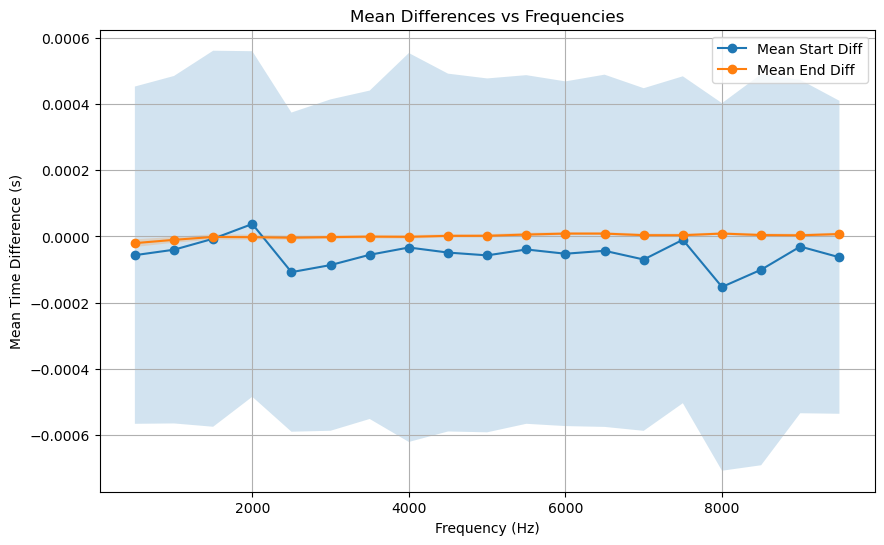

In [44]:
# Write a function to compute the mean and std of the differences against the frequencies using simulate_detections
# then plot the results

def compute_mean_diffs_vs_freqs(frequencies, n_trials=500, fs=100_000, duration=3.0, shape='ramp_up', noise_std=0.01):
    mean_start_diffs = []
    mean_end_diffs = []
    std_start_diffs = []
    std_end_diffs = []
    for f0 in frequencies:
        start_diffs, end_diffs = simulate_detections(n_trials=n_trials, fs=fs, f0=f0, duration=duration, shape=shape, noise_std=noise_std)
        mean_start_diffs.append(np.mean(start_diffs))
        mean_end_diffs.append(np.mean(end_diffs))
        std_start_diffs.append(np.std(start_diffs))
        std_end_diffs.append(np.std(end_diffs))
    return (np.array(mean_start_diffs), np.array(mean_end_diffs), np.array(std_start_diffs), np.array(std_end_diffs))

def plot_mean_diffs_vs_freqs(frequencies, mean_start_diffs, mean_end_diffs, std_start_diffs, std_end_diffs):
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, mean_start_diffs, label='Mean Start Diff', marker='o')
    plt.plot(frequencies, mean_end_diffs, label='Mean End Diff', marker='o')
    plt.fill_between(frequencies, mean_start_diffs - std_start_diffs, mean_start_diffs + std_start_diffs, alpha=0.2)
    plt.fill_between(frequencies, mean_end_diffs - std_end_diffs, mean_end_diffs + std_end_diffs, alpha=0.2)
    plt.title('Mean Differences vs Frequencies')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Mean Time Difference (s)')
    plt.legend()
    plt.grid()
    plt.show()

frequencies = np.arange(500, 10_000, 500)  # Frequencies from 500 Hz to 10 kHz
print(frequencies)
mean_start_diffs, mean_end_diffs, std_start_diffs, std_end_diffs = compute_mean_diffs_vs_freqs(frequencies)
plot_mean_diffs_vs_freqs(frequencies, mean_start_diffs, mean_end_diffs, std_start_diffs, std_end_diffs)

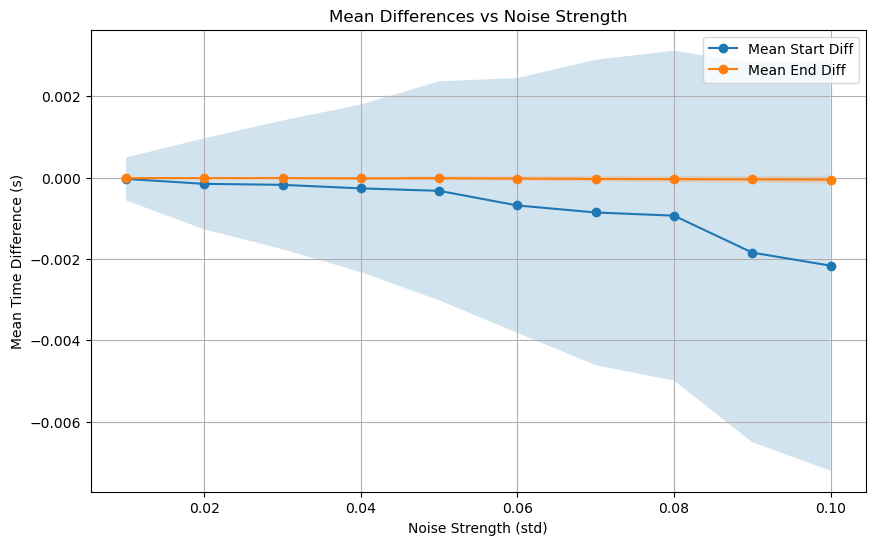

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Write a function to compute the mean and std of the differences against the noise strength using simulate_detections
# then plot the results
def compute_mean_diffs_vs_noise_strength(noise_strengths, n_trials=200, fs=100_000, f0=1000, duration=3.0, shape='ramp_up'):
    mean_start_diffs = []
    mean_end_diffs = []
    std_start_diffs = []
    std_end_diffs = []
    for noise_std in noise_strengths:
        start_diffs, end_diffs = simulate_detections(n_trials=n_trials, fs=fs, f0=f0, duration=duration, shape=shape, noise_std=noise_std)
        mean_start_diffs.append(np.mean(start_diffs))
        mean_end_diffs.append(np.mean(end_diffs))
        std_start_diffs.append(np.std(start_diffs))
        std_end_diffs.append(np.std(end_diffs))
    return (np.array(mean_start_diffs), np.array(mean_end_diffs), np.array(std_start_diffs), np.array(std_end_diffs))

def plot_mean_diffs_vs_noise_strength(noise_strengths, mean_start_diffs, mean_end_diffs, std_start_diffs, std_end_diffs):
    plt.figure(figsize=(10, 6))
    plt.plot(noise_strengths, mean_start_diffs, label='Mean Start Diff', marker='o')
    plt.plot(noise_strengths, mean_end_diffs, label='Mean End Diff', marker='o')
    plt.fill_between(noise_strengths, mean_start_diffs - std_start_diffs, mean_start_diffs + std_start_diffs, alpha=0.2)
    plt.fill_between(noise_strengths, mean_end_diffs - std_end_diffs, mean_end_diffs + std_end_diffs, alpha=0.2)
    plt.title('Mean Differences vs Noise Strength')
    plt.xlabel('Noise Strength (std)')
    plt.ylabel('Mean Time Difference (s)')
    plt.legend()
    plt.grid()
    plt.show()

noise_strengths = np.arange(0.01, 0.1+0.01, 0.01)  # Noise strengths from 0.01 to including 0.1
mean_start_diffs, mean_end_diffs, std_start_diffs, std_end_diffs = compute_mean_diffs_vs_noise_strength(noise_strengths)
plot_mean_diffs_vs_noise_strength(noise_strengths, mean_start_diffs, mean_end_diffs, std_start_diffs, std_end_diffs)